# 멋진 작사가 만들기


## 라이브러리 확인

In [54]:
import os
import glob
import re
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split

## 데이터 셋팅

In [55]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()       
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)    
    sentence = re.sub(r'[" "]+', " ", sentence)     
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)  
    sentence = sentence.strip()
    sentence = ' ' + sentence + ' '      
    
    return sentence

In [56]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000,  
        filters=' ',    
        oov_token=""  
    )
    tokenizer.fit_on_texts(corpus)   # 우리가 구축한 corpus로부터 Tokenizer가 사전을 자동구축하게 됩니다.

    # 이후 tokenizer를 활용하여 모델에 입력할 데이터셋을 구축하게 됩니다.
    tensor = tokenizer.texts_to_sequences(corpus)   # tokenizer는 구축한 사전으로부터 corpus를 해석해 Tensor로 변환합니다.

    # 입력 데이터의 시퀀스 길이를 일정하게 맞추기 위한 padding  메소드를 제공합니다.
    # maxlen의 디폴트값은 None입니다. 이 경우 corpus의 가장 긴 문장을 기준으로 시퀀스 길이가 맞춰집니다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=15)  

    print(tensor,tokenizer)
    return tensor, tokenizer

In [57]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

In [58]:
def generate_text(model, tokenizer, init_sentence="", max_len=20):

    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index[""]

    while True:
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력합니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]    

        test_tensor = tf.concat([test_tensor, 
        tf.expand_dims(predict_word, axis=0)], axis=-1)

        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""

    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated 

In [59]:
txt_file_path = os.getenv('HOME')+'/aiffel//lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ["Busted flat in Baton Rouge, waitin' for a train", "And I's feelin' near as faded as my jeans", 'Bobby thumbed a diesel down, just before it rained']


In [60]:
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
        
    corpus.append(preprocess_sentence(sentence))
        
corpus[:10]

[' busted flat in baton rouge , waitin for a train ',
 ' and i s feelin near as faded as my jeans ',
 ' bobby thumbed a diesel down , just before it rained ',
 ' it rode us all the way to new orleans i pulled my harpoon out of my dirty red bandanna ',
 ' i was playin soft while bobby sang the blues , yeah ',
 ' windshield wipers slappin time , i was holdin bobby s hand in mine ',
 ' we sang every song that driver knew freedom s just another word for nothin left to lose ',
 ' nothin , don t mean nothin hon if it ain t free , no no ',
 ' and , feelin good was easy , lord , when he sang the blues ',
 ' you know , feelin good was good enough for me ']

In [61]:
tensor, tokenizer = tokenize(corpus)

[[3602 1689   12 ...    0    0    0]
 [   6    3   14 ...    0    0    0]
 [ 802    1    7 ...    0    0    0]
 ...
 [   3   20  712 ... 4176    2    0]
 [   3   20  712 ... 4176    2    0]
 [   3   20  712 ... 4176   18    0]] <keras_preprocessing.text.Tokenizer object at 0x7f9c27b31a90>


In [62]:
src_input = tensor[:, :-1]  
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[3602 1689   12    1 3993    2 1098   26    7  679    0    0    0    0]
[1689   12    1 3993    2 1098   26    7  679    0    0    0    0    0]


In [63]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=2020)

In [64]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1 

In [65]:
dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

In [66]:
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val)).shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

## 모델 학습


In [67]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.drop1 = tf.keras.layers.Dropout(0.3)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.drop1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 2048
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [68]:
for src_sample, tgt_sample in dataset.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 14, 7001), dtype=float32, numpy=
array([[[-1.40274467e-04,  1.15720140e-04,  5.71893062e-04, ...,
          2.02883757e-03,  3.88143642e-04, -1.30820263e-04],
        [-1.78507849e-04,  3.95364681e-04,  5.47354342e-04, ...,
          3.84186953e-03,  9.47056804e-04,  6.15734598e-06],
        [-5.25217329e-04,  9.85348015e-04,  1.75583205e-04, ...,
          5.22084069e-03,  1.19616336e-03, -5.61682973e-04],
        ...,
        [-3.43791419e-03,  1.14908768e-02, -2.94147478e-03, ...,
          6.67383149e-03, -3.20917432e-04,  1.18555815e-03],
        [-3.73143773e-03,  1.28370607e-02, -3.15822684e-03, ...,
          6.67496724e-03, -6.13140874e-04,  1.24532857e-03],
        [-3.95714166e-03,  1.39760636e-02, -3.28202476e-03, ...,
          6.67741522e-03, -9.32941388e-04,  1.27227989e-03]],

       [[-3.40777478e-04,  8.15521518e-04,  6.12877848e-05, ...,
          2.03594464e-04,  9.24713313e-05,  3.54862168e-05],
        [-1.04351995e-04,  1.38705049e-03, -5.

In [69]:
model.summary()

Model: "text_generator_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      multiple                  14338048  
_________________________________________________________________
lstm_6 (LSTM)                multiple                  33562624  
_________________________________________________________________
dropout_3 (Dropout)          multiple                  0         
_________________________________________________________________
lstm_7 (LSTM)                multiple                  33562624  
_________________________________________________________________
dense_3 (Dense)              multiple                  14345049  
Total params: 95,808,345
Trainable params: 95,808,345
Non-trainable params: 0
_________________________________________________________________


In [70]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [72]:
history = model.fit(dataset,
          epochs=4,
          validation_data=val_dataset,
          verbose=1)

Epoch 1/4
549/549 [==============================] - 284s 518ms/step - loss: 1.2350 - accuracy: 0.7354 - val_loss: 1.8766 - val_accuracy: 0.6730
Epoch 2/4
549/549 [==============================] - 285s 518ms/step - loss: 1.0378 - accuracy: 0.7727 - val_loss: 1.8671 - val_accuracy: 0.6844
Epoch 3/4
549/549 [==============================] - 285s 518ms/step - loss: 0.8948 - accuracy: 0.8017 - val_loss: 1.8767 - val_accuracy: 0.6915
Epoch 4/4
549/549 [==============================] - 285s 518ms/step - loss: 0.7947 - accuracy: 0.8234 - val_loss: 1.9016 - val_accuracy: 0.6967


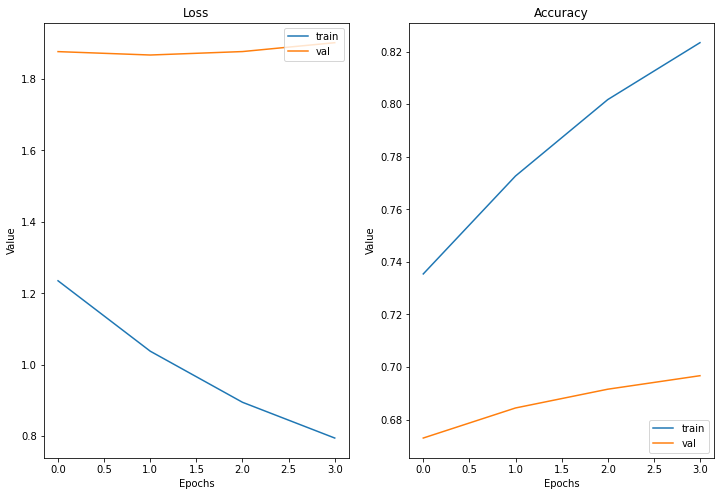

In [73]:
plot_curve(history.epoch, history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [82]:
generate_text(model, tokenizer, init_sentence=" i am", max_len=20)

'i am the  '